About aif360:

The AI Fairness 360 toolkit is an open-source library to help detect and mitigate bias in machine learning models. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models.


In [1]:
#I already installed these, thats why keep these as a comment
# Installing aif360
#!pip install aif360

About TensorFlow:

TensorFlow provides pre-built functions and advanced operations to ease the task of building different neural network models. TensorFlow is a Python library for fast numerical computing created and released by Google. It is a foundation library that can be used to create Deep Learning models directly or by using wrapper libraries that simplify the process built on top of TensorFlow.


In [2]:
#I already installed these, thats why keep these as a comment
#Installing tensorflow
#!pip install --upgrade tensorflow

In [3]:
#!pip install --ignore-installed 'aif360[all]'

In [4]:
#!pip install --user aif360[all]

# Import Panda's library to read the required dataset

In [5]:
# Explore the dataset we are going to use for the analysis
import pandas as pd
df = pd.read_csv('compas-scores-two-years.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [6]:
#Importing lobriries from ai360models, 
#Matplotlib is a plotting library, a big data numerical handling resource.
%matplotlib inline
# Load all necessary packages for PRE-PROCESSING analysis
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm #tqdm is a library in Python which is used for creating Progress Meters or Progress Bars. 

from aif360.datasets import BinaryLabelDataset #Base class for all structured datasets with binary labels
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset #these datasets are used for ML modeling
from aif360.metrics import BinaryLabelDatasetMetric #Class for computing metrics based on single BinaryLabelDatasets.
from aif360.metrics import ClassificationMetric #Classification Metrics evaluate a model's performance.
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


# Compas is a landmark dataset to study algorithmic (un)fairness. This dataset usually used to predict recidivism

In [7]:
## import dataset
dataset_used = "compas"
protected_attribute_used = 2 # 1 - sex, 2 - race
## we'll focus on race attribute, but you can experiment with gender as well

# Copy the dataset into my own PC

In [8]:
## you need to copy a data file if it was not copied during the installation; I copied in D drive 
!copy compas-scores-two-years.csv G:\


        1 file(s) copied.


# Load the Dataset, specify options and specify options; in this model we use 'race' as a protected attribute

In [9]:
# Load dataset compas and specify options
if protected_attribute_used == 1:
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
    dataset_orig = load_preproc_data_compas(['sex'])
else:
    privileged_groups = [{'race': 1}]
    unprivileged_groups = [{'race': 0}]
    dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

#random seed for calibrated equal odds prediction
randseed = np.random.seed(3040384) # It initializes the pseudorandom number generator

# Get the dataset and Split the dataset into train, test and validation

In [10]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.6], shuffle=True)

# Clean up training data and display properties of the data

In [11]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(3694, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


In [12]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.127718


#### Original validation dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.131713


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.160646


# Comments on the Above Outcome:

The ML model has no bias if the mean outcome is zero or very close to zero. A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group.

Here the outcomes are,

Difference in mean outcomes between unprivileged and privileged groups(Original training dataset)=-0.127718

Difference in mean outcomes between unprivileged and privileged groups(Original validation dataset) = -0.131713

Difference in mean outcomes between unprivileged and privileged groups(Original test dataset) = -0.160646

From the difference of the avobe unprivileged and privileged groups, it has been seen that the dataset is biased as the outcome not close to 0. Here in the model, the prevelege group is given more privileged.

# Apply classifier on original data; classifier indentify categorical labels from features

In [13]:
# Train classifier Logistic regression classifier on original data
#  NO CORRECTION for bias

scale_orig = StandardScaler() # scale inputs
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

In [14]:
#Obtain scores for original validation and test sets
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [15]:
#Find the optimal classification threshold from the validation set
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6647
Optimal classification threshold (no reweighing) = 0.4753


# Observing Outcome of Difference Matrics on Test Data

In [16]:
#Predictions from the original test set at the optimal classification threshold
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.4753


100%|██████████| 100/100 [00:00<00:00, 645.16it/s]

Balanced accuracy = 0.6632
Statistical parity difference = -0.3179
Disparate impact = 0.5946
Average odds difference = -0.2868
Equal opportunity difference = -0.1843
Theil index = 0.1993


# Observation about Outcome:

-Here, the balance accuracy is only 0.66, which is still not close to 1; indicates a bias.

-Statistical parity difference: Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group. The ideal value of this metric is 0.
Here, Statistical parity difference = -0.3179, which indicates bias in the model.

-Disparate Impact: Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group. The ideal value of this metric is 1. A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group. Fairness for this metric is between 0.8 and 1.25.Here, Disparate impact = 0.5946, which indicates bias in the model.

-Average Odds Difference: Computed as average difference of false positive rate (false positives / negatives) and true positive rate (true positives / positives) between unprivileged and privileged groups. The ideal value of this metric is 0. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group. 
Average odds difference = -0.2868, which indicates bias in the model.

-Equal Opportunity Difference: This metric is computed as the difference of true positive rates between the unprivileged and the privileged groups. The true positive rate is the ratio of true positives to the total number of actual positives for a given group. The ideal value is 0. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group.
Here, Equal opportunity difference = -0.1843, which indicates bias in the model.

Theil Index: Computed as the generalized entropy of benefit for all individuals in the dataset, with alpha = 1. It measures the inequality in benefit allocation for individuals. A value of 0 implies perfect fairness. Fairness is indicated by lower scores, higher scores are problematic.
Here, Theil index = 0.1993, which is close to 0.

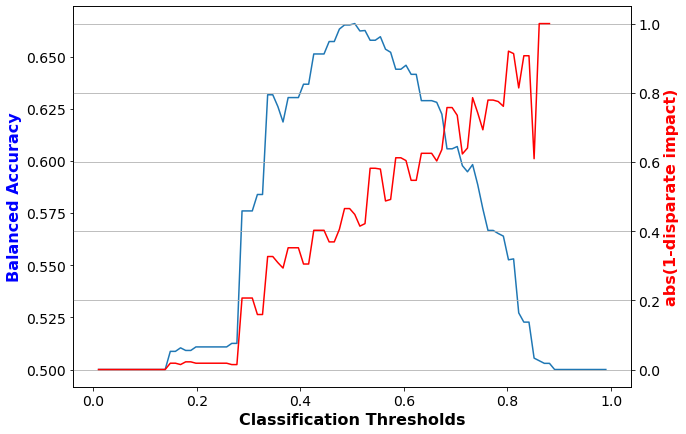

In [17]:
#Display results on abs(1-disparate impact) for all thresholds
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


# Observations About Graph:

-abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

-However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

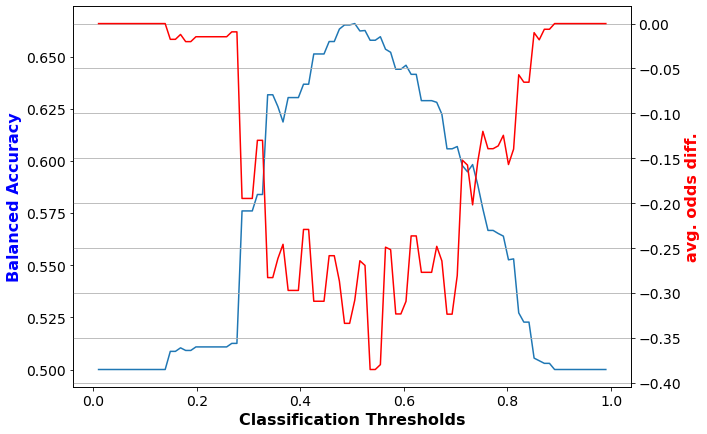

In [18]:
#Display results on average odds difference for all thresholds
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)



# Observations About Graph:

-average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

-However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

# PRE-PROCESSING TECHNIQUE - Reweighing

In [19]:
# Reweighing is a preprocessing technique that Weights the examples in each (group, label) 
# combination differently to ensure fairness before classification

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train) # Compute the weights for reweighing the dataset.
dataset_transf_train = RW.transform(dataset_orig_train) #Transform the dataset to a new dataset based on the estimated transformation.

# Removing the biasness by transforming the training dataset

In [20]:
#Removed the biasness by transforming the training dataset, thats why mean outcome come out zero
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [21]:
#Train classifier on transformed data
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

In [22]:
#Obtain scores for transformed test set
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [23]:
#Predictions from the transformed test set at the optimal classification threshold
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.4753


 59%|█████▉    | 59/100 [00:00<00:00, 584.07it/s]divide by zero encountered in double_scalars
invalid value encountered in double_scalars
100%|██████████| 100/100 [00:00<00:00, 621.11it/s]

Balanced accuracy = 0.6558
Statistical parity difference = -0.2120
Disparate impact = 0.7022
Average odds difference = -0.1781
Equal opportunity difference = -0.0934
Theil index = 0.2087


# Observations abut Outcome After Applying Reweighing Technique (Pre-processing):

-The outcome is not that much improved compared to the Predictions from original testing data.

-Here, the balance accuracy is only 0.6558, which is still not close to 1, indicates still bias is in the model.

-Statistical parity difference: Here, Statistical parity difference = -0.2120, which is improved a little bit compared to the predictions from original testing data but still not satisfactory as the value is far from 0.

-Disparate Impact: Here, Disparate Impact = 0.7022, which is improved a little bit compared to the predictions from original testing data but still not satisfactory as the value is far from 1.

-Average Odds Difference: Here, Average Odds Difference = -0.1781, which is improved compared to the predictions from original testing data but still not satisfactory as the value is far from 0.


-Equal Opportunity Difference: Here, Equal Opportunity Difference = -0.0934, which is very improved compared to the predictions from original testing data and close to 0.

-Theil Index: A value of 0 implies perfect fairness. Fairness is indicated by lower scores, higher scores are problematic. Here, Theil index = 0.2087, which is extended than a bit but in acceptable label.


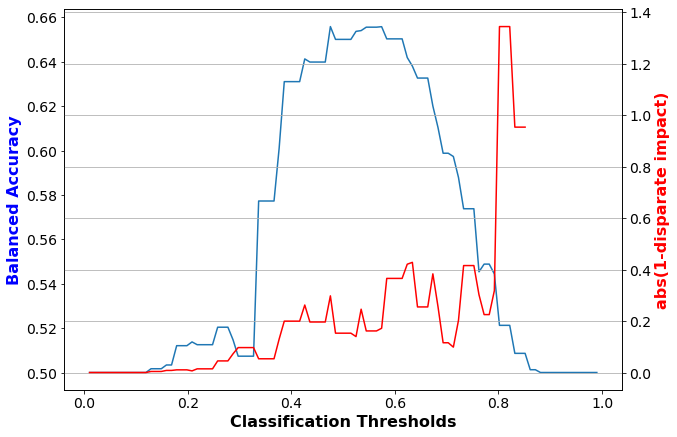

In [24]:
#Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)


# Observations About Graph:

-abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

-For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.

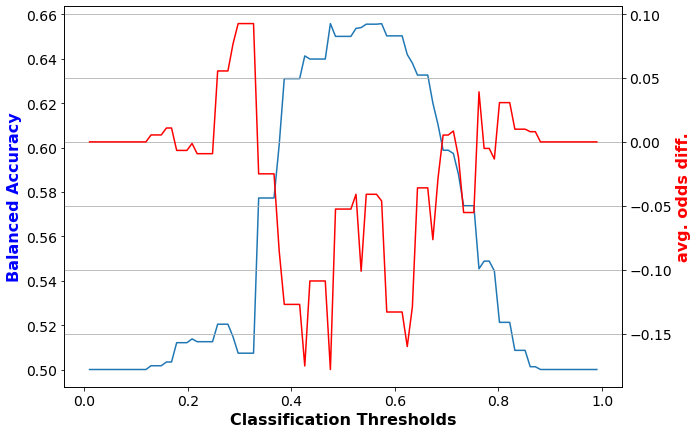

In [25]:
#Display results for all thresholds

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)



# Observations about Graph

-average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

-For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.

# POST_PROCESSING

In [26]:
#Let's reset our analysis for POST-PROCESSING with new imports and "fresh" dataset

if protected_attribute_used == 1:
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
    dataset_orig = load_preproc_data_compas(['sex'])
else:
    privileged_groups = [{'race': 1}]
    unprivileged_groups = [{'race': 0}]
    dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = np.random.seed(1)

# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.3], shuffle=True)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(dataset_orig_valid.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(dataset_orig_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

In [28]:
# Results before post-processing
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
-0.11956060645847982
Difference in GFNR between unprivileged and privileged groups
0.10500574979927796


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.10328212984169893
Difference in GFNR between unprivileged and privileged groups
0.09842904860256174


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.09489525973109098
Difference in GFNR between unprivileged and privileged groups
0.09802278917176316


In [29]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [30]:
#Transform validation and test data using the post processing algorithm
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

In [34]:
#Results after post-processing
cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))

cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Transformed testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.0854373777651859
Difference in GFNR between unprivileged and privileged groups
-0.01640351177443511


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.05075613761064052
Difference in GFNR between unprivileged and privileged groups
-0.009426865653612615


# Comments About GFPR and GFNR on validation and testing dataset before and after Post-processing

-After post-processing in validation dataset the Difference in GFPR and GFNR between unprivileged and privileged groups are reduced and become closed to zero, which were higher in the Original-Predicted validation dataset outcome. This indicates improvement of the model after post-processing. 

-After post-processing in testing dataset the Difference in GFPR and GFNR between unprivileged and privileged groups are reduced and become closed to zero, which were higher in the Original-Predicted validation dataset outcome. This indicates improvement of the model after post-processing. 

In [32]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))

#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:00<00:00, 42.23it/s]


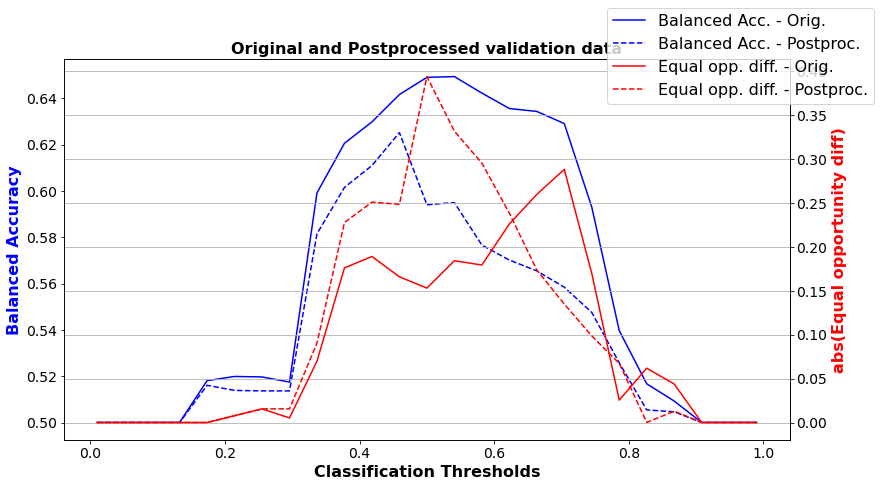

In [33]:
# Display results for all thresholds
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)


# Observations
# Compare red and blue lines for original and post-processed data. Do you see any improvemenet between solid and dashed lines?

-In the original validation data, where the balance accuracy is higher(plain blue line), the equal opportunity difference (plain red line) is lower; whereas, in postprocessed validation data, where the balance accuracy is higher(dot blue line), the equal opportunity difference (dot red line) is also higher. From the graph, it can be said that, the balance accuracy and abs(equal opportunity dif) is good in original validation data than preprocessed validation data because balance accuracy is higher and abs(equal opportunity difference) is lower in the original validation data compared to the postprocessed validation data.

Mentionable that,

-About Blue line: If the balance accuracy is close to 1, it indicates a good model. From the graph, I have observed that after post processing in validation data, the balance accuracy (the dot blue line) become lower than the original dataset's balance accuracy. That means, no improvement has happened after post-processing in the model rather it seems a negative impact.

-About Red line: If the equal opportunity difference is close to 0, it indicates a good model. From the graph, I have observed that after post processing in validation data, the equal opportunity difference (the dot red line) become higher than the original dataset's equal opportunity difference. That means, no improvement has happened after post-processing in the model rather it seems a negative impact.

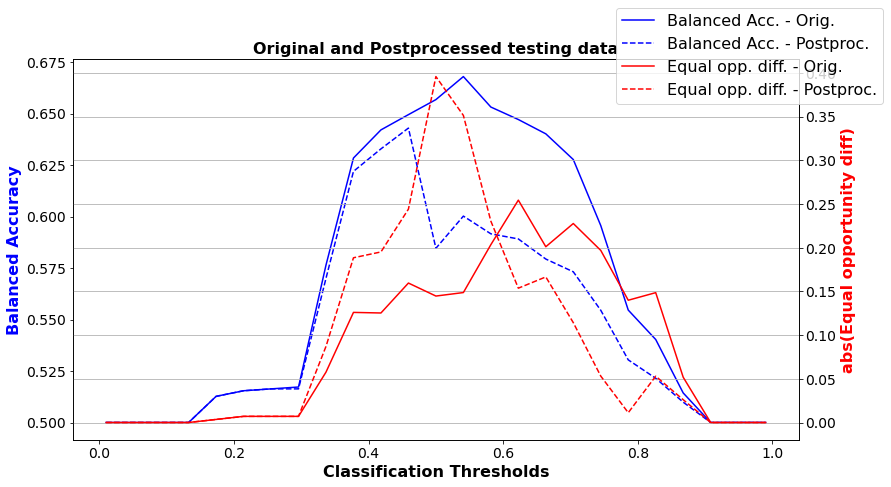

In [35]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

# Observation about the Graph

-In the original testing data, where the balance accuracy is higher(plain blue line), the equal opportunity difference (plain red line) is lower; whereas, in postprocessed testing data, where the balance accuracy is higher(dot blue line), the equal opportunity difference (dot red line) is also higher. From the graph, it can be said that, the balance accuracy and abs(equal opportunity dif) is good in original testing data than preprocessed testing data because balance accuracy is higher and abs(equal opportunity difference) is lower in the original testing data compared to the postprocessed testing data.

Mentionable that,

-If the balance accuracy is close to 1, it indicates a good model. From the graph, I have observed that after post processing in testing data, the balance accuracy (the dot blue line) become lower than the original data's balance accuracy. That means, no improvement has happened after post-processing in the model rather it seems a negative impact.

-If the equal opportunity difference is close to 0, it indicates a good model. From the graph, I have observed that after post processing in validation dataset, the equal opportunity difference (the dot red line) become higher than the original dataset's equal opportunity difference. That means, no improvement has happened after post-processing in the model rather it seems a negative impact.

# IN-PROCESSING

In [36]:
#Let's reset our analysis for IN-PROCESSING with new imports and "fresh" dataset
#IN-PROCESSING

%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas, load_preproc_data_german

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


In [37]:
if protected_attribute_used == 1:
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
    dataset_orig = load_preproc_data_compas(['sex'])
else:
    privileged_groups = [{'race': 1}]
    unprivileged_groups = [{'race': 0}]
    dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = np.random.seed(1)

# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.3], shuffle=True)

In [38]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.127093
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.192173


In [39]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.127093
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.192173


In [40]:
# Load in-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [41]:
plain_model.fit(dataset_orig_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.710728
epoch 1; iter: 0; batch classifier loss: 0.635184
epoch 2; iter: 0; batch classifier loss: 0.641355
epoch 3; iter: 0; batch classifier loss: 0.669490
epoch 4; iter: 0; batch classifier loss: 0.655102
epoch 5; iter: 0; batch classifier loss: 0.603991
epoch 6; iter: 0; batch classifier loss: 0.617000
epoch 7; iter: 0; batch classifier loss: 0.619914
epoch 8; iter: 0; batch classifier loss: 0.627568
epoch 9; iter: 0; batch classifier loss: 0.581358
epoch 10; iter: 0; batch classifier loss: 0.596083
epoch 11; iter: 0; batch classifier loss: 0.593827
epoch 12; iter: 0; batch classifier loss: 0.635558
epoch 13; iter: 0; batch classifier loss: 0.591654
epoch 14; iter: 0; batch classifier loss: 0.600573
epoch 15; iter: 0; batch classifier loss: 0.535410
epoch 16; iter: 0; batch classifier loss: 0.564851
epoch 17; iter: 0; batch cla

In [42]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [45]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.270207
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.251481


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.651037
Test set: Balanced classification accuracy = 0.650351
Test set: Disparate impact = 0.687425
Test set: Equal opportunity difference = -0.163222
Test set: Average odds difference = -0.204379
Test set: Theil_index = 0.160672


# In-processing Model Observation Before debiasing:

-Balanced classification accuracy = 0.650351, which is almost same with original and pre-processing.

-Disparate impact = 0.687425, which indicates biasness in the model. The ideal value of this metric is 1.

-Average Odds Difference: The ideal value of this metric is 0. Average odds difference = -0.204379, which indicates biasness in the model.

-Equal Opportunity Difference: The ideal value is 0. Here, Equal opportunity difference = -0.163222, which indicates biasness in the model.

-Theil Index: A value of 0 implies perfect fairness. Fairness is indicated by lower scores, higher scores are problematic. Here, Theil index = 0.160672, which is in acceptable label.

In [46]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [47]:
# Let's correct for bias during training
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)

In [48]:
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.694574; batch adversarial loss: 0.792574
epoch 1; iter: 0; batch classifier loss: 0.690589; batch adversarial loss: 0.849275
epoch 2; iter: 0; batch classifier loss: 0.688475; batch adversarial loss: 0.775688
epoch 3; iter: 0; batch classifier loss: 0.637499; batch adversarial loss: 0.771330
epoch 4; iter: 0; batch classifier loss: 0.616753; batch adversarial loss: 0.808692
epoch 5; iter: 0; batch classifier loss: 0.639391; batch adversarial loss: 0.773547
epoch 6; iter: 0; batch classifier loss: 0.670063; batch adversarial loss: 0.762157
epoch 7; iter: 0; batch classifier loss: 0.676512; batch adversarial loss: 0.761536
epoch 8; iter: 0; batch classifier loss: 0.677942; batch adversarial loss: 0.740900
epoch 9; iter: 0; batch classifier loss: 0.686322; batch adversarial loss: 0.732215
epoch 10; iter: 0; batch classifier loss: 0.710100; batch adversarial loss: 0.729936
epoch 11; iter: 0; batch classifier loss: 0.586718; batch adversarial loss:

In [49]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [50]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())



display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.270207
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.251481


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.247683
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.227198


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.651037
Test set: Balanced classification accuracy = 0.650351
Test set: Disparate impact = 0.687425
Test set: Equal opportunity difference = -0.163222
Test set: Average odds difference = -0.204379
Test set: Theil_index = 0.160672


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.647430
Test set: Balanced classification accuracy = 0.646801
Test set: Disparate impact = 0.707698
Test set: Equal opportunity difference = -0.137319
Test set: Average odds difference = -0.180825
Test set: Theil_index = 0.169550


# In-processing Model Observation After Debiasing:
    
-The results of the matrix are almost same after debiasing.

-Balanced classification accuracy = 0.0.647430, which is a bit reduced from before debiasing outcome.

-Disparate impact = 0.707698, which is a little bit improved after debiasing.

-Average Odds Difference: The ideal value of this metric is 0. Average odds difference = -0.180825, which is improved compared to before debiasing matrix value but still indicates biasness in the model as it is far from 0.

-Equal Opportunity Difference: The ideal value is 0. Here, Equal opportunity difference = -0.137319, hich is improved compared to before debiasing matrix value but still indicates biasness in the model as it is far from 0.

-Theil Index: A value of 0 implies perfect fairness. Fairness is indicated by lower scores, higher scores are problematic. Here, Theil index = 0.169550, which is in acceptable label.
